In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

In [11]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shafa\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shafa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Pre-Processing Data

In [7]:
tweets_data = pd.read_csv('tweets_data.csv')

print(tweets_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      100 non-null    object 
 1   Content   100 non-null    object 
 2   Username  0 non-null      float64
 3   Likes     100 non-null    int64  
 4   Retweets  100 non-null    int64  
 5   Replies   100 non-null    int64  
 6   URL       100 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 5.6+ KB
None


In [9]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('indonesian'))  

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'@\w+', '', text)    
    text = re.sub(r'#\w+', '', text)    
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower()  
    text = ' '.join([word for word in text.split() if word not in stop_words])  
    return text

tweets_data['cleaned_content'] = tweets_data['Content'].apply(clean_text)
print(tweets_data[['Content', 'cleaned_content']].head())


                                             Content  \
0  RT @tilehopper: Gue sebenernya ga mau bilang k...   
1  @Grizella_Zee Melalui program Makan Bergizi Gr...   
2  @prabowoisme Kualitas gizi dari ikan dan susu ...   
3  RT @tilehopper: Gue sebenernya ga mau bilang k...   
4  @prabowoisme Program Makan Bergizi Gratis sang...   

                                     cleaned_content  
0  rt gue sebenernya ga bilang takut ngejinx spee...  
1  program makan bergizi gratis gizi seimbang das...  
2  kualitas gizi ikan susu olahan fokus program m...  
3  rt gue sebenernya ga bilang takut ngejinx spee...  
4  program makan bergizi gratis memperhatikan kua...  


# Sentimen Analysis

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    score = analyzer.polarity_scores(text)
    return score['compound'] 

tweets_data['sentiment_score'] = tweets_data['cleaned_content'].apply(analyze_sentiment_vader)

tweets_data['sentiment_label'] = tweets_data['sentiment_score'].apply(
    lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
)

print(tweets_data[['cleaned_content', 'sentiment_score', 'sentiment_label']].head())


                                     cleaned_content  sentiment_score  \
0  rt gue sebenernya ga bilang takut ngejinx spee...           0.0000   
1  program makan bergizi gratis gizi seimbang das...           0.0516   
2  kualitas gizi ikan susu olahan fokus program m...           0.0516   
3  rt gue sebenernya ga bilang takut ngejinx spee...           0.0000   
4  program makan bergizi gratis memperhatikan kua...           0.0516   

  sentiment_label  
0         neutral  
1        positive  
2        positive  
3         neutral  
4        positive  


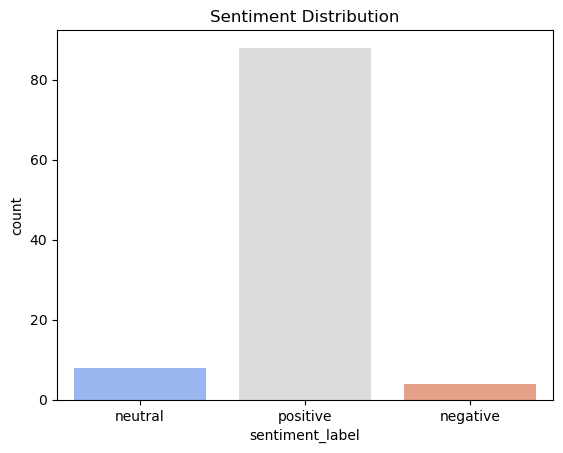

In [25]:
#Sentiment Distribution
sns.countplot(data=tweets_data, x='sentiment_label', palette='coolwarm')
plt.title('Sentiment Distribution')
plt.show()


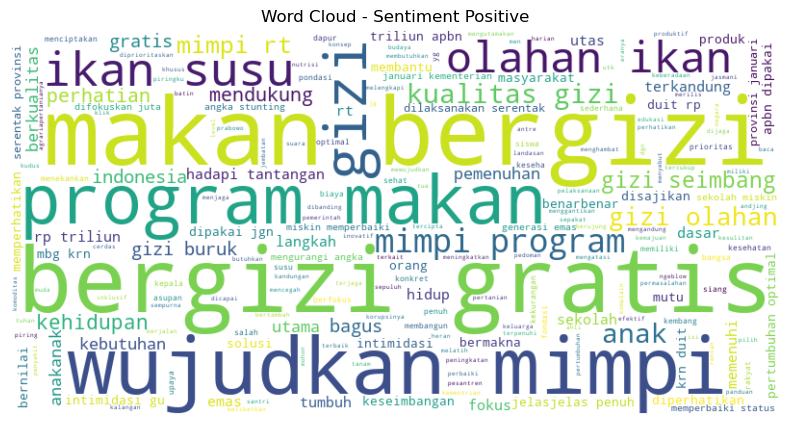

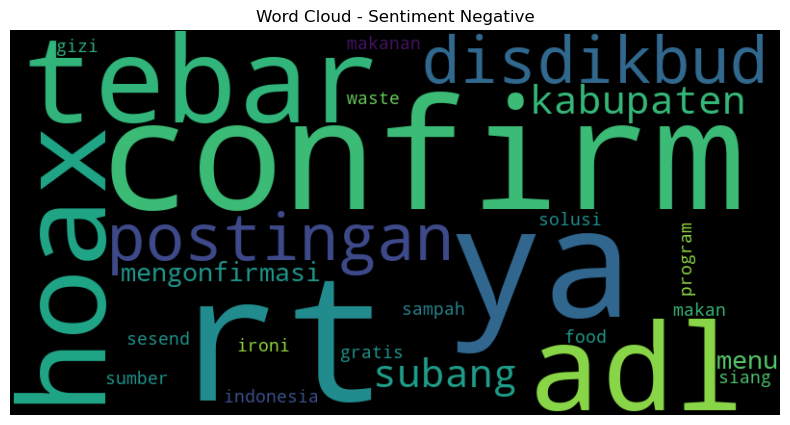

In [26]:
positive_text = ' '.join(tweets_data[tweets_data['sentiment_label'] == 'positive']['cleaned_content'])
negative_text = ' '.join(tweets_data[tweets_data['sentiment_label'] == 'negative']['cleaned_content'])

# WordCloud for positif sentiment
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentiment Positive')
plt.show()

# WordCloud for negatif sentiment
negative_wc = WordCloud(width=800, height=400, background_color='black').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentiment Negative')
plt.show()


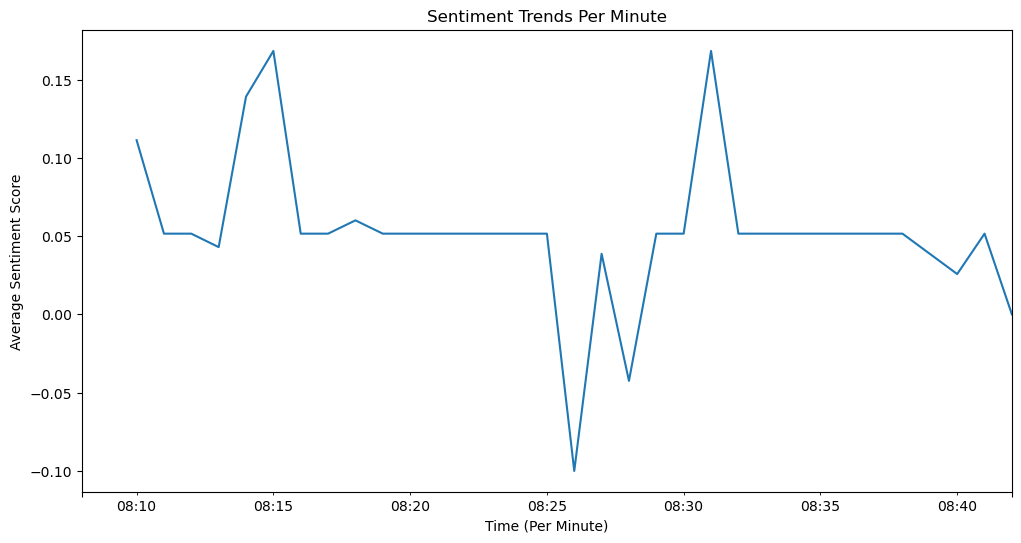

In [27]:
#Time Based Sentiment Trends
tweets_data['Date'] = pd.to_datetime(tweets_data['Date'])

sentiment_trends = tweets_data.groupby(pd.Grouper(key='Date', freq='T'))['sentiment_score'].mean()

plt.figure(figsize=(12, 6))
sentiment_trends.plot()
plt.title('Sentiment Trends Per Minute')
plt.xlabel('Time (Per Minute)')
plt.ylabel('Average Sentiment Score')
plt.show()

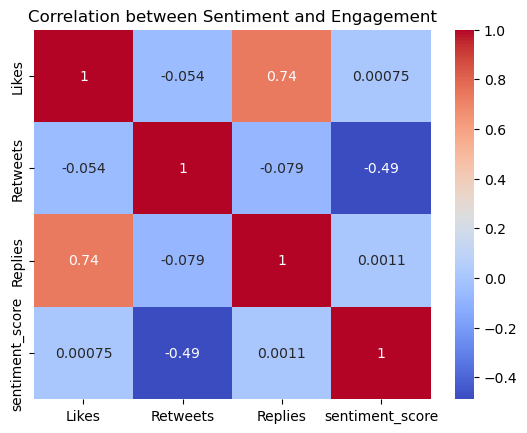

In [31]:
#Correlation of Sentiment with Interaction
correlation = tweets_data[['Likes', 'Retweets', 'Replies', 'sentiment_score']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Sentiment and Engagement')
plt.show()

In [30]:
#Frequently Discussed Topics
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(tweets_data['cleaned_content'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

for i, topic in enumerate(lda.components_):
    print(f"Topik {i}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print("\n")


Topik 0:
['tebar', 'hoax', 'subang', 'ya', 'mengonfirmasi', 'menu', 'postingan', 'disdikbud', 'adl', 'rt']


Topik 1:
['sekolah', 'bagus', 'indonesia', 'bergizi', 'utas', 'program', 'gizi', 'gratis', 'makan', 'anak']


Topik 2:
['olahan', 'ikan', 'susu', 'program', 'wujudkan', 'mimpi', 'bergizi', 'makan', 'gratis', 'gizi']


Topik 3:
['ronald', 'reagan', 'ketololan', 'bilang', 'sebenernya', 'speedrun', 'ngejinx', 'pas', 'mangk', 'rt']


Topik 4:
['seimbang', 'program', 'anak', 'kebutuhan', 'mimpi', 'wujudkan', 'gratis', 'makan', 'bergizi', 'gizi']




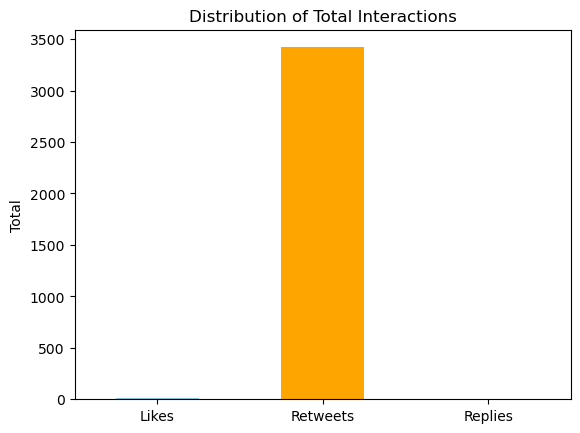

In [33]:
#Interaction Distribution
interactions = ['Likes', 'Retweets', 'Replies']
tweets_data[interactions].sum().plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title('Distribution of Total Interactions')
plt.ylabel('Total')
plt.xticks(rotation=0)
plt.show()

In [34]:
#Top tweets
top_interaction = tweets_data.sort_values(by='Likes', ascending=False).head(5)
print("Top 5 Tweets with the Highest Likes:")
print(top_interaction[['Date', 'Content', 'Likes']])


Top 5 Tweets with the Highest Likes:
                        Date  \
74 2025-01-09 08:16:59+00:00   
75 2025-01-09 08:16:56+00:00   
93 2025-01-09 08:11:02+00:00   
63 2025-01-09 08:20:09+00:00   
72 2025-01-09 08:17:18+00:00   

                                              Content  Likes  
74  Program Makan Bergizi Gratis mulai dilaksanaka...     13  
75  Wujudkan Mimpi Kita\n\nMakan Bergizi Gratis am...      1  
93  📰 UTAS \n\nProgram Makan Bergizi Gratis yang d...      1  
63  @CuitanMakmak Dalam program Makan Bergizi Grat...      0  
72  Keberadaan Makan Bergizi Gratis sangat penting...      0  


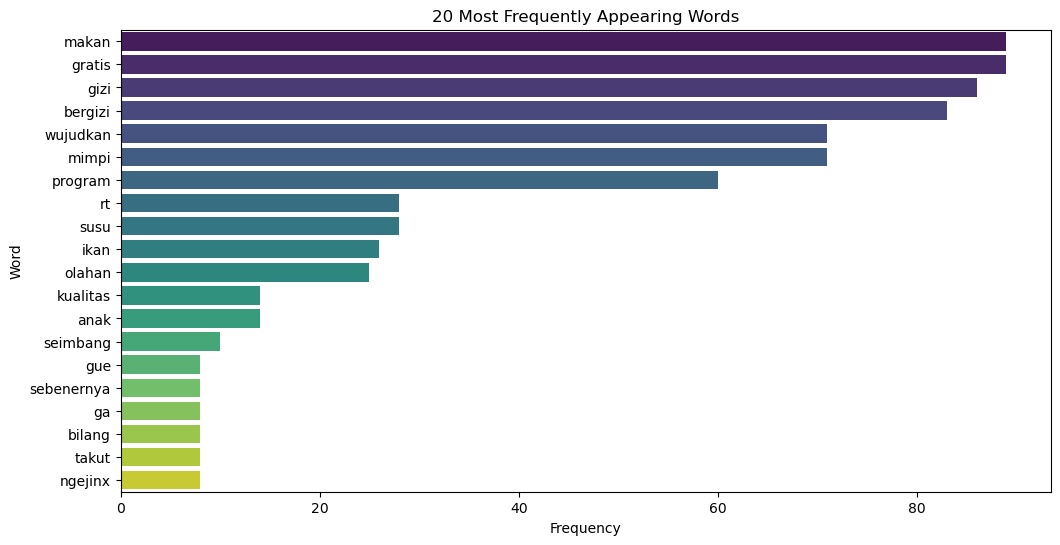

In [36]:
#Words Frequency
from collections import Counter
all_words = ' '.join(tweets_data['cleaned_content']).split()
word_freq = Counter(all_words)

most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('20 Most Frequently Appearing Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [37]:
#Tweets Based on Content Similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(tweets_data['cleaned_content'])

kmeans = KMeans(n_clusters=5, random_state=42)
tweets_data['Cluster'] = kmeans.fit_predict(tfidf_matrix)

print(tweets_data[['Content', 'Cluster']].head())

                                             Content  Cluster
0  RT @tilehopper: Gue sebenernya ga mau bilang k...        2
1  @Grizella_Zee Melalui program Makan Bergizi Gr...        3
2  @prabowoisme Kualitas gizi dari ikan dan susu ...        0
3  RT @tilehopper: Gue sebenernya ga mau bilang k...        2
4  @prabowoisme Program Makan Bergizi Gratis sang...        0


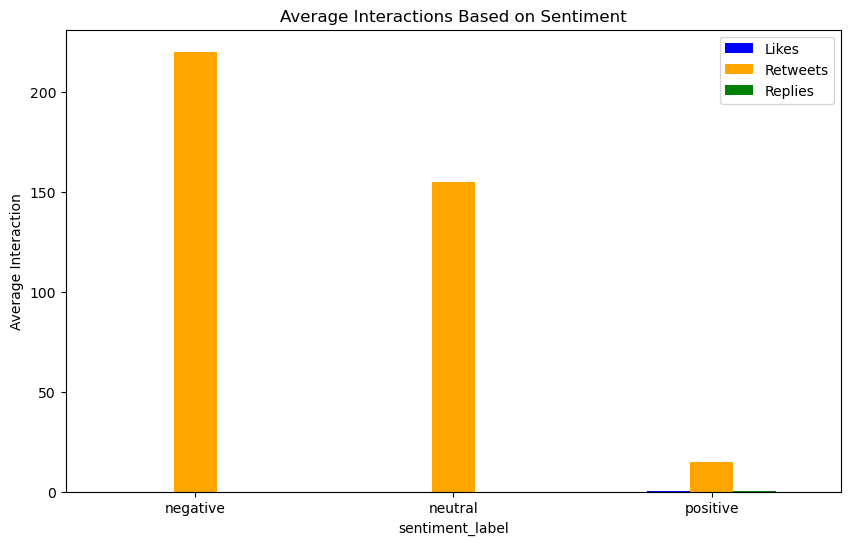

In [40]:
#Positive VS Negative Sentiment
sentiment_interaction = tweets_data.groupby('sentiment_label')[['Likes', 'Retweets', 'Replies']].mean()

sentiment_interaction.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange', 'green'])
plt.title('Average Interactions Based on Sentiment')
plt.ylabel('Average Interaction')
plt.xticks(rotation=0)
plt.show()